In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import medfilt

In [51]:
def find_disease(labels,disease_id,disease_array):
    
    for index,i in enumerate(labels):
        if disease_id in i:
            disease_array[index] = 1
            
    return disease_array

def load_signal(filename):
    """
    filename - str, should include data path
    """
    
    record = json.load(open(filename))

    #add info
    if record['age'] == 'NaN':
        record['age'] = -1


    #add labels
    if record['labels_SNOMEDCT'] is None:
        record['labels_SNOMEDCT'] = []
    if record['labels'] is None:
        record['labels'] = []
    if record['labels_full'] is None:
        record['labels_full'] = []
        
    ecg = np.load(filename[:-5]+'.npy')
    #ecg*= record['amp_conversion']
    
    for i in range(12):
        ecg[:,i] -= np.median(ecg[:,i])
    
    return ecg,record

In [44]:
np.median(ecg[:,i])

IndexError: index 43100 is out of bounds for axis 1 with size 12

In [37]:
DATASET_LIST = ['A','B','C','D','E','F']
df_general = pd.DataFrame()

fs_list = []

for dataset in DATASET_LIST:
    print('Start processing dataset ',dataset)
    DATA_PATH = '../data/'+dataset+'/formatted/'

    list_records = [record for record in os.listdir(DATA_PATH) if record.find('.json') != -1]

    age = []
    gender = []
    label = []
    shape = []
    n_channels = []

    labels_SNOMEDCT = []
    labels = []
    labels_full = []

    for record in tqdm(list_records):
        record = json.load(open(DATA_PATH + record))

        #add info
        if record['age'] == 'NaN':
            record['age'] = -1

        age.append(int(record['age']))
        gender.append(record['sex'])
        label.append(record['sex'])
        shape.append(record['shape'][0])
        n_channels.append(record['shape'][1])

        #add labels
        if record['labels_SNOMEDCT'] is None:
            record['labels_SNOMEDCT'] = []
        if record['labels'] is None:
            record['labels'] = []
        if record['labels_full'] is None:
            record['labels_full'] = []

        labels_SNOMEDCT.append(record['labels_SNOMEDCT'])
        labels.append(record['labels'])
        labels_full.append(record['labels_full'])

    #list of unique diseases
    _251146004 = np.zeros((len(age)))
    _251146004 = find_disease(labels_SNOMEDCT,251146004,_251146004)

    for i in range(len(labels_SNOMEDCT)):
        for j in range(len(labels_SNOMEDCT[i])): 
            labels_SNOMEDCT[i][j] = str(labels_SNOMEDCT[i][j])

        labels_SNOMEDCT[i] = str(labels_SNOMEDCT[i])


    df = pd.DataFrame({'age': age, 
                       'gender': gender,
                       'label':label,
                       'shape':shape,
                       'n_channels':n_channels,
                       'labels_SNOMEDCT':labels_SNOMEDCT,
                        'labels':labels,
                        'labels_full':labels_full,        

    '251146004' : _251146004,
    'record_name':list_records,

    })
    df['dataset'] = dataset
    
    df_general = df_general.append(df)
    fs_list.append(record['fs'])

  2%|▏         | 118/6877 [00:00<00:05, 1171.30it/s]

Start processing dataset  A


  0%|          | 7/3453 [00:00<00:54, 63.39it/s]

Start processing dataset  B


  0%|          | 0/74 [00:00<?, ?it/s]

Start processing dataset  C


  1%|          | 3/516 [00:00<00:23, 22.08it/s]

Start processing dataset  D


  0%|          | 6/21837 [00:00<06:46, 53.67it/s]

Start processing dataset  E


  0%|          | 8/10344 [00:00<02:18, 74.67it/s]

Start processing dataset  F


100%|██████████| 10344/10344 [02:17<00:00, 75.18it/s]


In [38]:
fs_list

[500, 500, 257, 1000, 500, 500]

In [40]:
df_general

,age,gender,label,shape,n_channels,labels_SNOMEDCT,labels,labels_full,251146004,record_name,dataset
0,54,male,male,8680,12,"['59118001', '284470004']","[RBBB, PAC]","[right bundle branch block, premature atrial c...",0.0,A2652.json,A
1,68,male,male,5000,12,['426783006'],[SNR],[sinus rhythm],0.0,A4228.json,A
2,40,male,male,15500,12,['59118001'],[RBBB],[right bundle branch block],0.0,A2889.json,A
3,83,male,male,5000,12,['284470004'],[PAC],[premature atrial contraction],0.0,A6312.json,A
4,22,female,female,11000,12,['59118001'],[RBBB],[right bundle branch block],0.0,A5549.json,A
...,...,...,...,...,...,...,...,...,...,...,...
10339,54,female,female,5000,12,['59931005'],[TInv],[t wave inversion],0.0,E07944.json,F
10340,55,male,male,5000,12,[],[],[],0.0,E03617.json,F
10341,61,female,female,5000,12,['426783006'],[SNR],[sinus rhythm],0.0,E07346.json,F
10342,43,female,female,5000,12,['164934002'],[TAb],[t wave abnormal],0.0,E03863.json,F


In [41]:
df_qrs = df_general[df_general['251146004'] == 1]
df_qrs

,age,gender,label,shape,n_channels,labels_SNOMEDCT,labels,labels_full,251146004,record_name,dataset
6,62,male,male,5000,12,"['251146004', '39732003', '426783006']","[LQRSV, LAD, SNR]","[low qrs voltages, left axis deviation, sinus ...",1.0,HR03158.json,E
105,76,male,male,5000,12,"['164889003', '251146004']","[AF, LQRSV]","[atrial fibrillation, low qrs voltages]",1.0,HR01164.json,E
245,83,female,female,5000,12,"['251146004', '426783006', '445118002']","[LQRSV, SNR, LAnFB]","[low qrs voltages, sinus rhythm, left anterior...",1.0,HR00348.json,E
290,62,female,female,5000,12,"['251146004', '426177001', '426783006']","[LQRSV, SB, SNR]","[low qrs voltages, sinus bradycardia, sinus rh...",1.0,HR03207.json,E
378,68,female,female,5000,12,"['251146004', '426783006']","[LQRSV, SNR]","[low qrs voltages, sinus rhythm]",1.0,HR06348.json,E
...,...,...,...,...,...,...,...,...,...,...,...
10180,58,female,female,5000,12,"['59118001', '251146004', '164934002', '111975...","[RBBB, LQRSV, TAb, LQT]","[right bundle branch block, low qrs voltages, ...",1.0,E00557.json,F
10191,49,female,female,5000,12,['251146004'],[LQRSV],[low qrs voltages],1.0,E02071.json,F
10280,68,male,male,5000,12,"['251146004', '59931005', '164934002']","[LQRSV, TInv, TAb]","[low qrs voltages, t wave inversion, t wave ab...",1.0,E09764.json,F
10309,54,male,male,5000,12,"['427084000', '251146004']","[STach, LQRSV]","[sinus tachycardia, low qrs voltages]",1.0,E03406.json,F


# Check Distribution of r peaks amplitude for low qrs amps 

In [52]:
#check 1st lead 
lead = 1
lead-=1

amps = []

dataset = df_general['dataset'].tolist()
record_name = df_general['record_name'].tolist()
label = df_general['251146004'].values

for i in tqdm(range(df_general.shape[0])):
    ecg,record = load_signal( '../data/'+dataset[i]+'/formatted/'+record_name[i])
    rpeaks = record['rpeaks'][lead]
    amps.append(np.mean(ecg[rpeaks,lead]))
    if i == 3:
        break
amps = np.array(amps)

 16%|█▌        | 6947/43101 [04:26<24:26, 24.65it/s]/home/dmitrii/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dmitrii/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 43101/43101 [23:39<00:00, 30.36it/s]  


In [54]:
np.where(amps < 0)

/home/dmitrii/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(array([    3,     4,    19, ..., 42980, 43064, 43090]),)

In [62]:
for i in tqdm(range(df_general.shape[0])):
    ecg,record = load_signal( '../data/'+dataset[i]+'/formatted/'+record_name[i])
    rpeaks = record['rpeaks'][lead]
    if i == 4:
        break

  0%|          | 4/43101 [00:00<09:51, 72.92it/s]


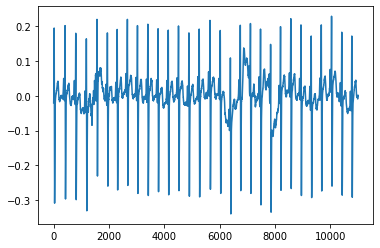

In [63]:
plt.plot(ecg[:,0])

In [64]:
record

{'filename': 'A5549',
 'datetime': '12-May-2020',
 'channel_order': ['I',
  'II',
  'III',
  'aVR',
  'aVL',
  'aVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'],
 'age': '22',
 'sex': 'female',
 'amp_conversion': 1000,
 'fs': 500,
 'length': 11000,
 'num_leads': 12,
 'labels_SNOMEDCT': [59118001],
 'labels': ['RBBB'],
 'labels_full': ['right bundle branch block'],
 'shape': [11000, 12],
 'hr': 81.34578619062307,
 'rpeaks': [[34,
   427,
   815,
   1197,
   1582,
   1958,
   2312,
   2680,
   3044,
   3420,
   3789,
   4157,
   4528,
   4904,
   5276,
   5664,
   6037,
   6403,
   6761,
   7127,
   7491,
   7856,
   8215,
   8585,
   8953,
   9324,
   9687,
   10059,
   10428,
   10791],
  [19,
   412,
   799,
   1183,
   1567,
   1942,
   2297,
   2665,
   3030,
   3405,
   3774,
   4142,
   4513,
   4889,
   5261,
   5650,
   6021,
   6387,
   6746,
   7112,
   7476,
   7841,
   8199,
   8570,
   8938,
   9308,
   9672,
   10043,
   10412,
   10775],
  [19,
   413,
   800,
   118

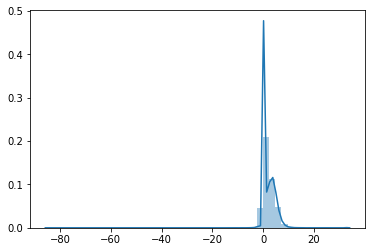

In [61]:
sns.distplot(amps[np.where(label == 0)],norm_hist=False)
#sns.distplot(amps[np.where(label == 1)],norm_hist=False)

In [17]:
ecg[rpeaks].shape

(17, 12)

In [9]:
df_qrs['dataset'].unique()

array(['E', 'F'], dtype=object)

In [10]:
ecg,record = load_signal( '../data/'+'E'+'/formatted/'+'HR03158.json')

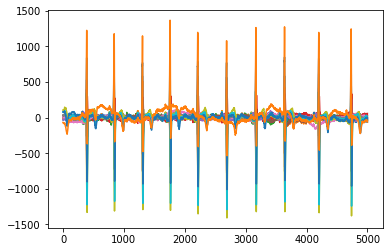

In [45]:
plt.plot(ecg)

In [12]:
record

{'filename': 'HR03158',
 'datetime': '04-Jun-2020',
 'channel_order': ['I',
  'II',
  'III',
  'aVR',
  'aVL',
  'aVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'],
 'age': '62',
 'sex': 'male',
 'amp_conversion': 200,
 'fs': 500,
 'length': 5000,
 'num_leads': 12,
 'labels_SNOMEDCT': [251146004, 39732003, 426783006],
 'labels': ['LQRSV', 'LAD', 'SNR'],
 'labels_full': ['low qrs voltages', 'left axis deviation', 'sinus rhythm'],
 'shape': [5000, 12],
 'hr': 74.87983518752273,
 'rpeaks': [[304,
   698,
   1099,
   1511,
   1926,
   2332,
   2733,
   3128,
   3523,
   3919,
   4321,
   4725],
  [303, 698, 1098, 1511, 1925, 2331, 2732, 3127, 3522, 3919, 4321, 4724],
  [312, 706, 1107, 1520, 1933, 2339, 2739, 3135, 3530, 3928, 4329, 4733],
  [304, 698, 1099, 1511, 1925, 2331, 2732, 3127, 3522, 3919, 4321, 4725],
  [305, 700, 1101, 1513, 1927, 2332, 2734, 3129, 3524, 3920, 4322, 4725],
  [313, 708, 1108, 1521, 1935, 2341, 2742, 3137, 3532, 3928, 4330, 4734],
  [311, 705, 1105, 1517, 193

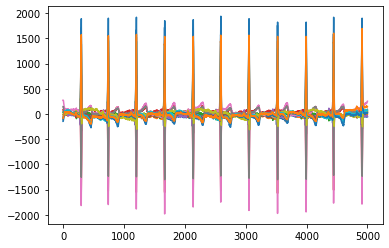

In [28]:
ecg,record = load_signal( '../data/'+'F'+'/formatted/'+'E03863.json')
plt.plot(ecg)